# Pattern Expert (Rule-based) – Logistic Regression + TimeSeries CV (Train) + Val Select

Train a multi-symbol candlestick-pattern expert that:
- pulls pattern + OHLCV labels from the versioned Feast/DVC assets,
- runs a time-ordered grid search on the train split, ranks candidates by validation ROC-AUC, then refits the best configuration,
- logs lineage, metrics, artifacts, and the final model to MLflow for downstream stacking.

Use this notebook whenever you need a reproducible pattern-only baseline for the 2019–2023 horizon before blending with other experts.

In [1]:
# Install deps (Colab)
!pip -q install "mlflow>=2.12,<3" "dagshub==0.6.4" "dvc[s3]" scikit-learn pandas pyarrow matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.5/445.5 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.

## 1) Credentials / Environment
Set these using Colab `userdata` (or replace with your own method).

In [2]:
import os
from google.colab import userdata

# AWS
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = userdata.get('AWS_DEFAULT_REGION') or 'us-east-1'

# MLflow (DAGsHub)
os.environ["DAGSHUB_USER_TOKEN"] = userdata.get('DAGSHUB_TOKEN')

missing = [k for k in ['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','DAGSHUB_USER_TOKEN'] if not os.environ.get(k)]
if missing:
    raise ValueError(f"Missing secrets in Colab userdata: {missing}")
print('Secrets loaded:', ', '.join(['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','AWS_DEFAULT_REGION','DAGSHUB_USER_TOKEN']))

Secrets loaded: AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_DEFAULT_REGION, DAGSHUB_USER_TOKEN


## 2) Clone repo + pull DVC dataset
This ensures `git_sha` and `.dvc` pointers exist locally, and that the dataset version is reproducible.

In [3]:
from pathlib import Path

REPO_NAME = "dissertation"  # change if needed
REPO_URL = f"https://github.com/Roncool13/{REPO_NAME}.git"
BRANCH_OR_COMMIT = "main"  # or commit hash for full reproducibility

if not Path(REPO_NAME).exists():
    !git clone {REPO_URL}
%cd {REPO_NAME}
!git checkout {BRANCH_OR_COMMIT}

# Pull DVC-versioned dataset artifacts
!dvc pull data/features/ohlcv_features.parquet
!dvc pull data/features/ohlcv_feature_metadata.json

# Pattern feature artifacts (produced by your pattern feature build pipeline)
!dvc pull data/features/pattern_features.parquet
!dvc pull data/features/pattern_feature_metadata.json

%cd ..


Cloning into 'dissertation'...
remote: Enumerating objects: 972, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 972 (delta 56), reused 75 (delta 30), pack-reused 864 (from 1)
Receiving objects: 100% (972/972), 336.90 KiB | 4.43 MiB/s, done.
Resolving deltas: 100% (601/601), done.
/content/dissertation
Already on 'main'
Your branch is up to date with 'origin/main'.
Fetching
!
  0% |          |0/? [00:00<?,    ?files/s]
                                           
!
  0% |          |0/? [00:00<?,    ?files/s]
                                           
Fetching from s3:   0% 0/1 [00:00<?, ?file/s]
Fetching from s3:   0% 0/1 [00:00<?, ?file/s{'info': ''}]

  0% 0.00/17.4M [00:00<?, ?B/s]

  0% 0.00/17.4M [00:00<?, ?B/s{'info': ''}]

 97% 16.9M/17.4M [00:00<00:00, 130MB/s{'info': ''}]

                                                   
Fetching from s3: 100% 1/1 [00:00<00:00,  3.34file/s{'info': ''}]
Fetching
Building wo

## 3) MLflow setup

In [4]:
import mlflow
import dagshub

dagshub.init(repo_owner='Roncool13', repo_name='dissertation-mlflow', mlflow=True)
mlflow.set_experiment("dissertation-pattern-prediction-multisym-2019-2023")

# IMPORTANT: keep autolog OFF for GridSearchCV(refit=False) runs
mlflow.sklearn.autolog(disable=True)

print('MLflow tracking URI:', mlflow.get_tracking_uri())


Accessing as Roncool13

Initialized MLflow to track repo "Roncool13/dissertation-mlflow"

Repository Roncool13/dissertation-mlflow initialized!

MLflow tracking URI: https://dagshub.com/Roncool13/dissertation-mlflow.mlflow


## 4) Reproducibility + dataset lineage logging (Git + DVC)

In [5]:
import subprocess
import hashlib
import json
import numpy as np
import random
from pathlib import Path

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

def _run(cmd):
    return subprocess.check_output(cmd, text=True).strip()

def _sha256_file(path):
    h = hashlib.sha256()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(1024*1024), b''):
            h.update(chunk)
    return h.hexdigest()

def log_code_and_data_version():
    # Git commit
    try:
        mlflow.set_tag('git_sha', _run(['git','rev-parse','HEAD']))
    except Exception:
        mlflow.set_tag('git_sha', 'unavailable')

    # DVC pointer hashes
    for tag, p in [
        ('dvc_ptr_pattern_features_sha256', f'{REPO_NAME}/data/features/pattern_features.parquet.dvc'),
        ('dvc_ptr_pattern_metadata_sha256', f'{REPO_NAME}/data/features/pattern_feature_metadata.json.dvc'),
        ('dvc_ptr_ohlcv_features_sha256', f'{REPO_NAME}/data/features/ohlcv_features.parquet.dvc'),
        ('dvc_ptr_ohlcv_metadata_sha256', f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc'),
    ]:
        try:
            mlflow.set_tag(tag, _sha256_file(p))
        except Exception:
            mlflow.set_tag(tag, 'unavailable')

    # Log pointer files + metadata as artifacts
    for p, ap in [
        (f'{REPO_NAME}/data/features/pattern_features.parquet.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/pattern_feature_metadata.json.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/ohlcv_features.parquet.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/pattern_feature_metadata.json', 'dataset_metadata'),
        (f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json', 'dataset_metadata'),
    ]:
        try:
            mlflow.log_artifact(p, artifact_path=ap)
        except Exception:
            pass

    meta_ohlcv = json.loads(Path(f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json').read_text())
    splits = meta_ohlcv.get('splits', {})

    mlflow.log_params({
        'dataset_name': 'pattern_features',
        'label_source': 'ohlcv_features',
        'start_year': meta_ohlcv.get('start_year'),
        'end_year': meta_ohlcv.get('end_year'),
        'horizon_days': meta_ohlcv.get('horizon_days'),
        'split_scheme': splits.get('scheme'),
        'seed': SEED,
        'feature_shift_days': 1,
    })

    if 'train' in splits and 'val' in splits and 'test' in splits:
        mlflow.set_tags({
            'train_period': f"{splits['train']['start']}:{splits['train']['end']}",
            'val_period': f"{splits['val']['start']}:{splits['val']['end']}",
            'test_period': f"{splits['test']['start']}:{splits['test']['end']}",
        })

print('Seed set to', SEED)


Seed set to 42


## 5) Load dataset + apply metadata-driven splits

We use OHLCV metadata splits (train/val/test date ranges) so that expert models are comparable on the same time windows.

In [6]:
import pandas as pd
import json
from pathlib import Path

# Load features + label source
pat = pd.read_parquet(f'{REPO_NAME}/data/features/pattern_features.parquet')
ohlcv = pd.read_parquet(f'{REPO_NAME}/data/features/ohlcv_features.parquet')
meta_ohlcv = json.loads(Path(f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json').read_text())

label_col = f"y_up_{meta_ohlcv['horizon_days']}d" if 'horizon_days' in meta_ohlcv else 'y_up_5d'
print('Label col:', label_col)

# Ensure datetimes
pat['date'] = pd.to_datetime(pat['date'])
ohlcv['date'] = pd.to_datetime(ohlcv['date'])

# Keep only key + label
label_df = ohlcv[['symbol','date',label_col]].dropna().copy()

# Merge on same trading day
# IMPORTANT: We'll shift pattern features by 1 day so they only use info known BEFORE the label day.
df = pat.merge(label_df, on=['symbol','date'], how='inner').sort_values(['symbol','date']).reset_index(drop=True)

# Identify feature columns (pattern signals)
feature_cols = [c for c in df.columns if c not in ['symbol','date',label_col]]

# Shift features within each symbol by 1 day (avoid same-day leakage)
df[feature_cols] = df.groupby('symbol', sort=False)[feature_cols].shift(1)

# Drop rows created by shifting + any remaining NaNs in features/label
df = df.dropna(subset=feature_cols + [label_col]).reset_index(drop=True)

print('Merged rows:', len(df))
print('Date min/max:', df['date'].min(), df['date'].max())
print('Rows per year:', df['date'].dt.year.value_counts().sort_index().to_dict())


Label col: y_up_5d
Merged rows: 25893
Date min/max: 2019-01-02 00:00:00 2023-12-21 00:00:00
Rows per year: {2019: 5124, 2020: 5292, 2021: 5208, 2022: 5208, 2023: 5061}


In [7]:
# Build train/val/test splits using OHLCV metadata dates
import pandas as pd

splits = meta_ohlcv.get('splits', {})
assert 'train' in splits and 'val' in splits and 'test' in splits, 'splits missing in OHLCV metadata'

def _in_range(d, start, end):
    d = pd.to_datetime(d)
    return (d >= pd.to_datetime(start)) & (d <= pd.to_datetime(end))

train_mask = _in_range(df['date'], splits['train']['start'], splits['train']['end'])
val_mask   = _in_range(df['date'], splits['val']['start'], splits['val']['end'])
test_mask  = _in_range(df['date'], splits['test']['start'], splits['test']['end'])

train_df = df.loc[train_mask].copy()
val_df   = df.loc[val_mask].copy()
test_df  = df.loc[test_mask].copy()

print('train rows', len(train_df), 'date_min', train_df['date'].min(), 'date_max', train_df['date'].max(), 'pos_rate', float(train_df[label_col].mean()))
print('val rows', len(val_df), 'date_min', val_df['date'].min(), 'date_max', val_df['date'].max(), 'pos_rate', float(val_df[label_col].mean()))
print('test rows', len(test_df), 'date_min', test_df['date'].min(), 'date_max', test_df['date'].max(), 'pos_rate', float(test_df[label_col].mean()))


train rows 15624 date_min 2019-01-02 00:00:00 date_max 2021-12-31 00:00:00 pos_rate 0.5273297491039427
val rows 5208 date_min 2022-01-03 00:00:00 date_max 2022-12-30 00:00:00 pos_rate 0.5276497695852534
test rows 5061 date_min 2023-01-02 00:00:00 date_max 2023-12-21 00:00:00 pos_rate 0.5633274056510571


## 6) Build feature matrix (Pattern expert)

We train a **pattern-based expert** using only engineered candlestick-pattern features keyed by (`symbol`, `date`).

We exclude:
- key: `date`
- label: `y_up_*d`

We keep `symbol` and one-hot encode it (helps the model learn per-symbol baselines).


In [8]:

# Build X/y (multi-symbol)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Keep symbol for one-hot encoding; exclude only date + label
exclude_cols = {'date', label_col}
X_cols = [c for c in df.columns if c not in exclude_cols]

# Basic safety: ensure label is int
train_df[label_col] = train_df[label_col].astype(int)
val_df[label_col]   = val_df[label_col].astype(int)
test_df[label_col]  = test_df[label_col].astype(int)

X_train, y_train = train_df[X_cols].copy(), train_df[label_col].copy()
X_val,   y_val   = val_df[X_cols].copy(),   val_df[label_col].copy()
X_test,  y_test  = test_df[X_cols].copy(),  test_df[label_col].copy()

# Identify categorical + numeric columns
cat_cols = ['symbol'] if 'symbol' in X_cols else []
num_cols = [c for c in X_cols if c not in set(cat_cols)]

# Coerce numeric columns to float (guards against accidental object dtype)
for _X in (X_train, X_val, X_test):
    for c in num_cols:
        _X[c] = pd.to_numeric(_X[c], errors='coerce')

# Fill NaNs created by coercion (rare; mostly for safety)
for _X in (X_train, X_val, X_test):
    _X[num_cols] = _X[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

print('Features total:', len(X_cols), '| numeric:', len(num_cols), '| categorical:', len(cat_cols))
print('Train rows:', len(X_train), 'Val rows:', len(X_val), 'Test rows:', len(X_test))


Features total: 18 | numeric: 17 | categorical: 1
Train rows: 15624 Val rows: 5208 Test rows: 5061


## 7) Train pattern expert (Train-CV on TRAIN, select via VAL)


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
import numpy as np
import pandas as pd

# ---- Preprocess: one-hot symbol + scale numeric ----
preprocess = ColumnTransformer(
    transformers=[
        ("sym", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
 )

base_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear", random_state=SEED))
])

param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l1", "l2"],
    "clf__class_weight": [None, "balanced"],
}

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=False,
    return_train_score=False,
)

grid.fit(X_train, y_train)

best_cv_idx = int(np.argmax(grid.cv_results_["mean_test_score"]))
best_cv_params = grid.cv_results_["params"][best_cv_idx]
best_cv_score = float(grid.cv_results_["mean_test_score"][best_cv_idx])

print("Best TRAIN-CV params:", best_cv_params)
print("Best TRAIN-CV mean ROC-AUC:", best_cv_score)

# ---- Select by VAL ROC-AUC ----
rows = []
for params in grid.cv_results_["params"]:
    m = Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000, solver="liblinear", random_state=SEED)),
])
    m.set_params(**params)
    m.fit(X_train, y_train)
    val_proba = m.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_proba)
    rows.append({"val_roc_auc": float(val_auc), **params})

val_rank = pd.DataFrame(rows).sort_values("val_roc_auc", ascending=False).reset_index(drop=True)
best_val = val_rank.iloc[0].to_dict()
best_val_params = {k: best_val[k] for k in param_grid.keys()}
best_val_auc = float(best_val["val_roc_auc"])

print("\nBest VAL-selected params:", best_val_params)
print("Best VAL ROC-AUC:", best_val_auc)

# ---- Fit final model with VAL-selected params on TRAIN ----
final_model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear", random_state=SEED)),
])
final_model.set_params(**best_val_params)
final_model.fit(X_train, y_train)

def eval_split(X, y, split_name):
    proba = final_model.predict_proba(X)[:, 1]
    pred = (proba >= 0.5).astype(int)
    metrics = {
        f"{split_name}_accuracy": float(accuracy_score(y, pred)),
        f"{split_name}_roc_auc": float(roc_auc_score(y, proba)),
        f"{split_name}_balanced_accuracy": float(balanced_accuracy_score(y, pred)),
        f"{split_name}_mcc": float(matthews_corrcoef(y, pred)),
    }
    return metrics, proba

val_metrics, val_proba = eval_split(X_val, y_val, "val_final")
test_metrics, test_proba = eval_split(X_test, y_test, "test")

print("\nVAL (final model):", val_metrics)
print("TEST:", test_metrics)

val_candidate_csv = "val_candidate_ranking_top10.csv"
val_rank.head(10).to_csv(val_candidate_csv, index=False)
print(f"Saved top-10 VAL ranking to {val_candidate_csv}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best TRAIN-CV params: {'clf__C': 0.001, 'clf__class_weight': None, 'clf__penalty': 'l1'}
Best TRAIN-CV mean ROC-AUC: 0.5

Best VAL-selected params: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__class_weight': 'balanced'}
Best VAL ROC-AUC: 0.5098063188601318

VAL (final model): {'val_final_accuracy': 0.5153609831029186, 'val_final_roc_auc': 0.5098063188601318, 'val_final_balanced_accuracy': 0.5127667128199667, 'val_final_mcc': 0.02561076782448333}
TEST: {'test_accuracy': 0.5087927287097411, 'test_roc_auc': 0.49594736148783236, 'test_balanced_accuracy': 0.5002250540018506, 'test_mcc': 0.0004506299049014898}
Saved top-10 VAL ranking to val_candidate_ranking_top10.csv


In [ ]:
import mlflow
from mlflow.models.signature import infer_signature

mlflow.sklearn.autolog(disable=True)

if mlflow.active_run():
    mlflow.end_run()

run_name = "pattern_lr_gridsearch_multisym_2019_2023"
with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id
    print("MLflow run:", run_id)
    log_code_and_data_version()

    mlflow.log_metric("traincv_best_mean_roc_auc", best_cv_score)
    mlflow.log_params({f"traincv_{k}": v for k, v in best_cv_params.items()})
    mlflow.log_metric("valselect_best_roc_auc", best_val_auc)
    mlflow.log_params({f"valselect_{k}": v for k, v in best_val_params.items()})

    mlflow.log_metrics({**val_metrics, **test_metrics})

    mlflow.log_artifact(val_candidate_csv, artifact_path="model_selection")

    input_example = X_train.head(5)
    proba_example = final_model.predict_proba(input_example)[:, 1]
    signature = infer_signature(input_example, proba_example)

    mlflow.sklearn.log_model(
        sk_model=final_model,
        artifact_path="model",
        input_example=input_example,
        signature=signature,
    )

result = mlflow.register_model(
    model_uri=f"runs:/{run_id}/model",
    name="pattern_lr_multisym_2019_2023"
)
print("Registered model version:", result.version)

## 8) Visualizations (ROC curves)

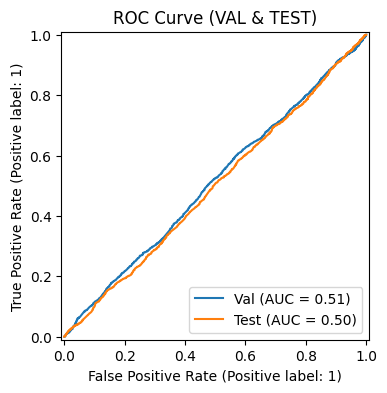

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
RocCurveDisplay.from_predictions(y_val, val_proba, name='Val', ax=ax)
RocCurveDisplay.from_predictions(y_test, test_proba, name="Test", ax=ax)
plt.title('ROC Curve (VAL & TEST)')
plt.show()
